# MLP PyTorch with MNIST
- **Task**: Classification
- **Data**: Fashion MNIST Dataset
- **Model**: MLP (Flatten -> Linear -> ReLU -> Linear)
- **Loss function**: Cross Entropy Loss
- **Optimization**: Stochastic Gradient Descent

In [5]:
!pip install -q watermark

In [3]:
%load_ext watermark
%watermark -a 'Nguyen Van Sy Thinh' -v -p torch

Author: Nguyen Van Sy Thinh

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.20.0

torch: 2.1.2



## 1. Import Library

In [4]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import time

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 2. Data

### 2.1. MNIST Dataset

#### 2.1.1. Load dataset to compute Mean and Std to Normalize Z-score

In [6]:
# Load dataset with only the ToTensor transform to compute mean and std
compute_transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.FashionMNIST(root='data', train=True, transform=compute_transform, download=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=False, num_workers=2)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

variance = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    variance += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(variance / (len(loader.dataset)*28*28))

print(mean, std)

100%|██████████| 26421880/26421880 [00:00<00:00, 63140806.42it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4296494.03it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 11113119.05it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9367582.21it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

tensor([0.2860]) tensor([0.3530])


#### 2.1.2. Load CFashionMNIST Dataset

In [7]:
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=2, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=2, shuffle=False)

### 2.2. Data Information

In [9]:
print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")

Number of training samples: 60000
Number of testing samples: 10000


In [10]:
print(f"Datatype of the 1st training sample: {trainset[0][0].type()}")
print(f"Size of the 1st training sample: {testset[0][0].size()}")

Datatype of the 1st training sample: torch.FloatTensor
Size of the 1st training sample: torch.Size([1, 28, 28])


### 2.3. Data Visualization

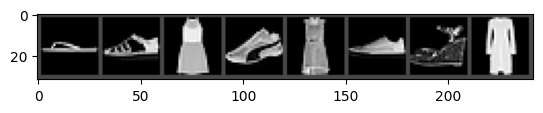

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*std + mean
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

## 3. Model

In [12]:
import torch
import torch.nn as nn

class MLPModel(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(n_inputs, 256)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(256, n_outputs)

    def forward(self, x):
        output = self.flatten(x)
        output = self.linear1(output)
        output = self.relu(output)
        output = self.linear2(output)
        return output

In [13]:
N_INPUTS = 28*28 # makes a 1D vector of 784
N_OUTPUTS = 10

In [14]:
model = MLPModel(n_inputs=N_INPUTS, n_outputs=N_OUTPUTS).to(device)

In [15]:
# Generating a random tensor
input_tensor = torch.rand(5, 28, 28).to(device)

# Feeding the tensor into the model
output = model(input_tensor)
print(output.shape)

torch.Size([5, 10])


## 4. Loss Function and Optimization

In [16]:
LR = 0.01
EPOCHS = 200

In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

## 5. Train

### 5.1. Evaluation Function

In [18]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [19]:
test_loss, test_accuracy = evaluate(model, testloader, criterion)
print(f'test_loss: {test_loss}')
print(f'test_accuracy: {test_accuracy}')

test_loss: 2.3107359409332275
test_accuracy: 6.86


In [20]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [21]:
# train
for epoch in range(EPOCHS):
    start_time = time.time()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()        

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Time: {time.time() - start_time:.3f}s")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/200], Loss: 1.6250, Accuracy: 58.47%, Test Loss: 1.1846, Test Accuracy: 69.33%, Time: 8.146s
Epoch [2/200], Loss: 1.0096, Accuracy: 71.94%, Test Loss: 0.8973, Test Accuracy: 72.80%, Time: 7.734s
Epoch [3/200], Loss: 0.8247, Accuracy: 74.38%, Test Loss: 0.7817, Test Accuracy: 74.85%, Time: 7.765s
Epoch [4/200], Loss: 0.7368, Accuracy: 76.08%, Test Loss: 0.7177, Test Accuracy: 76.02%, Time: 7.859s
Epoch [5/200], Loss: 0.6836, Accuracy: 77.27%, Test Loss: 0.6761, Test Accuracy: 77.09%, Time: 8.093s
Epoch [6/200], Loss: 0.6465, Accuracy: 78.20%, Test Loss: 0.6462, Test Accuracy: 77.84%, Time: 7.786s
Epoch [7/200], Loss: 0.6190, Accuracy: 78.94%, Test Loss: 0.6225, Test Accuracy: 78.49%, Time: 7.844s
Epoch [8/200], Loss: 0.5971, Accuracy: 79.58%, Test Loss: 0.6043, Test Accuracy: 79.02%, Time: 7.703s
Epoch [9/200], Loss: 0.5786, Accuracy: 80.13%, Test Loss: 0.5885, Test Accuracy: 79.56%, Time: 8.253s
Epoch [10/200], Loss: 0.5641, Accuracy: 80.58%, Test Loss: 0.5752, Test Accuracy: 

## 6. Inference

### 6.1. Loss Visualization

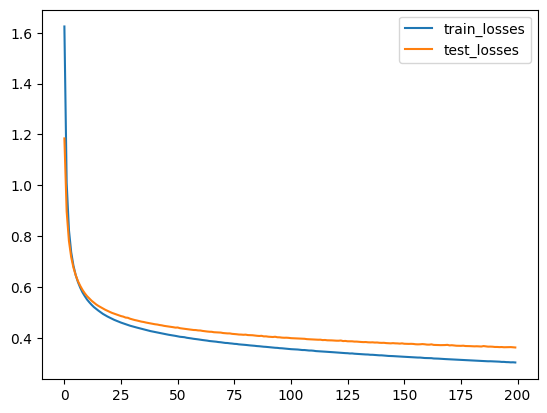

In [22]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

### 6.2. Accuracy Visualization 

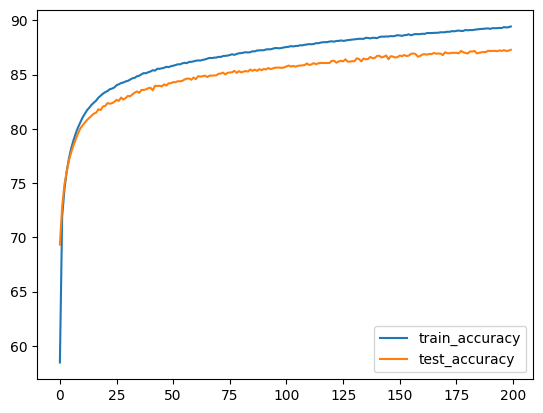

In [23]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

## 7. Conclusion
- **Train Accuracy**: 89.43%
- **Test Accuracy**: 87.28%